# Training a Lindsey encoder on classification

In [1]:
# general libraries
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# custom/special libraries

from retinal_rl.system.encoders import LindseyEncoderBase
from retinal_rl.helpers import get_cfg_jupyter
from retinal_rl.system.environment import register_retinal_environment
from retinal_rl.system.encoders import register_encoders
from retinal_rl.analysis.util import pad_dataset
from retinal_rl.analysis.statistics import spike_triggered_average

from sample_factory.envs.create_env import create_env
from sample_factory.utils.utils import log, AttrDict
from sample_factory.utils.timing import Timing

from retinal_rl.analysis.util import get_padded_mnist, LindseyClassificationEncoder
from retinal_rl.analysis.plot import plot_example_stim_torch

# automatic reloading
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

/gpfs01/berens/user/jmajnik/miniconda3/envs/reg_retinal-rl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda:0


# Defining custom dataset and model classes

# Extracting some parameters

In [5]:
experiment = 'postcosyne_complicated_appmnist-mnist_01'
analyze_ds_name = 'MNIST'

In [6]:
register_retinal_environment()
register_encoders()
cfg = get_cfg_jupyter(experiment) # this is not needed in script
cfg.analyze_ds_name = analyze_ds_name
# creating env to get appropriate 
env = create_env(cfg.env, cfg=cfg, env_config=AttrDict({'worker_index': 0, 'vector_index': 0}))

[2022-12-22 09:36:23,625][49203] Default env families supported: ['doom_*', 'atari_*', 'dmlab_*', 'mujoco_*', 'MiniGrid*']
[2022-12-22 09:36:23,626][49203] Env registry entry created: retinal_
[2022-12-22 09:36:23,628][49203] Adding model class <class 'retinal_rl.system.encoders.LindseyEncoder'> to registry (with name lindsey)


--env=retinal_appmnist_apples_gathering_01
--vvs_depth=1
--algo=APPO
--experiment=postcosyne_complicated_appmnist-mnist_01
--global_channels=16
--retinal_bottleneck=4
--analyze_acts=False
--res_h=90
--res_w=120


[2022-12-22 09:36:24,326][49203] Doom resolution: 160x120, resize resolution: (120, 90)


# Making padded dataset and preparing data

In [12]:
padded_ds = get_padded_mnist(cfg) # this has optional scaling and offset arguments

tcmalloc: large alloc 7776002048 bytes == 0x55b48f6aa000 @ 


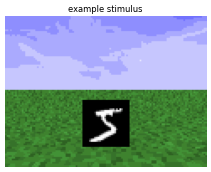

In [13]:
plot_example_stim_torch(padded_ds[0][0])

In [14]:
# train test split
train_size = int(0.8 * len(padded_ds))
test_size = len(padded_ds) - train_size

pad_mnist_trainset, pad_mnist_testset = torch.utils.data.random_split(padded_ds, [train_size, test_size])

In [15]:
# preparing iterables
train_loader = torch.utils.data.DataLoader(pad_mnist_trainset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(pad_mnist_testset, batch_size=100, shuffle=False)

data_train_iter = iter(train_loader)
images, labels = data_train_iter.next()

print("Shape of the minibatch of images: {}".format(images.shape))
print("Shape of the minibatch of labels: {}".format(labels.shape))

Shape of the minibatch of images: torch.Size([100, 3, 90, 120])
Shape of the minibatch of labels: torch.Size([100])


# Model fitting

In [16]:
# Instantiate model
model = LindseyClassificationEncoder(cfg, env.observation_space, Timing)
model = model.to(device)

LindseyClassificationEncoder(
  (activation): ELU(alpha=1.0, inplace=True)
  (nl_fc): ELU(alpha=1.0, inplace=True)
  (conv_head): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (fc1): Linear(in_features=21600, out_features=64, bias=True)
  (base_encoder): LindseyEncoderBase(
    (activation): ELU(alpha=1.0, inplace=True)
    (nl_fc): ELU(alpha=1.0, inplace=True)
    (conv_head): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
      (1): ELU(alpha=1.0, inplace=True)
      (2): Conv2d(16, 4, kernel_size=(7, 7), stride=(1, 1))
      (3): ELU(alpha=1.0, inplace=True)
      (4): Conv2d(4, 16, kernel_size=(7, 7), stride=(1, 1))
      (5): ELU(alpha=1.0, inplace=True)
    )
    (fc1): Linear(in_features=21600, out_

### Training

In [17]:
%%time
## Training

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.01)

# Iterate through train set minibatchs for a number of epochs
n_epochs = 30
a = model.base_encoder.fc1.weight.data.clone()

epoch_accuracy = []

for i in range(n_epochs):
    for images, labels in train_loader:
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        x = images.to(device)
        y = model(x.to(device))
        loss = criterion(y, labels.type(torch.LongTensor).to(device))

        # Backward pass
        loss.backward()
        optimizer.step()
    b = model.base_encoder.fc1.weight.data.clone()

    print(f'Epoch: {i+1}/{n_epochs} done')

    
    # evaluating for this epoch
    ## Testing
    correct = 0
    total = len(pad_mnist_testset)

    with torch.no_grad():
        # Iterate through test set minibatchs 
        for images, labels in test_loader:
            # Forward pass
            x = images.to(device)
            y = model(x.to(device))

            predictions = torch.argmax(y, dim=1)
            correct += torch.sum((predictions == labels.to(device)))#.float())
    acc = correct/total
    print('Test accuracy: {}'.format(acc))
    epoch_accuracy.append(acc.cpu())


Epoch: 1/30 done
Test accuracy: 0.9620000123977661
Epoch: 2/30 done
Test accuracy: 0.968666672706604
Epoch: 3/30 done
Test accuracy: 0.9732499718666077
Epoch: 4/30 done
Test accuracy: 0.9739999771118164
Epoch: 5/30 done
Test accuracy: 0.9736666679382324
Epoch: 6/30 done
Test accuracy: 0.9761666655540466
Epoch: 7/30 done
Test accuracy: 0.9750833511352539
Epoch: 8/30 done
Test accuracy: 0.9756666421890259
Epoch: 9/30 done
Test accuracy: 0.9775833487510681
Epoch: 10/30 done
Test accuracy: 0.9734166264533997
Epoch: 11/30 done
Test accuracy: 0.9778333306312561
Epoch: 12/30 done
Test accuracy: 0.9803333282470703
Epoch: 13/30 done
Test accuracy: 0.9800833463668823
Epoch: 14/30 done
Test accuracy: 0.9795833230018616
Epoch: 15/30 done
Test accuracy: 0.981416642665863
Epoch: 16/30 done
Test accuracy: 0.9788333177566528
Epoch: 17/30 done
Test accuracy: 0.9795833230018616
Epoch: 18/30 done
Test accuracy: 0.9798333048820496
Epoch: 19/30 done
Test accuracy: 0.9792500138282776
Epoch: 20/30 done
Test 

Text(0.5, 0, 'epoch')

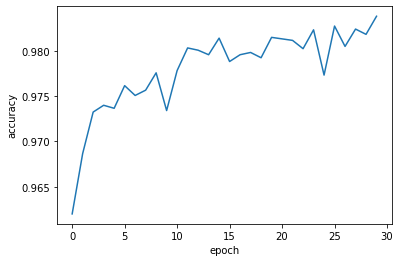

In [18]:
# plot training accuracy
plt.plot(epoch_accuracy)
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [19]:
# export model as numpy object for later explainability analysis
t_stamp =  str(np.datetime64('now')).replace('-','').replace('T','_').replace(':', '')
np.save(f'pytorch/models/mnist_class_100epoch{t_stamp}.npy', model)